<a href="https://www.kaggle.com/code/emmanuelniyioriolowo/1-knn-rildc?scriptVersionId=285427049" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports

In [1]:
!pip install scikit-learn==1.4.2 imbalanced-learn==0.12.2
!pip install --upgrade ctgan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 14.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.4.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

In [2]:
import os
import numpy as np 
import pandas as pd 
import torch
import random
import shap
from ctgan import CTGAN
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import matthews_corrcoef, make_scorer
from collections import Counter
from imblearn.over_sampling import SMOTE


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/indian-liver-patient-ilp-dataset/Indian Liver Patient Dataset (ILPD).csv


### **Project Overview**

This notebook aims to replicate key parts of the paper: “Tabular Data Generation to Improve Classification of Liver Disease Diagnosis” by _Mohammad Alauthman et al._

The original study evaluated the performance of several machine learning algorithms on the Indian Liver Patient Dataset (ILPD) while examining the impact of two data augmentation strategies: Generative Adversarial Networks (GANs) and the Synthetic Minority Oversampling Technique (SMOTE).

Their results indicate that K-Nearest Neighbors (KNN) combined with SMOTE achieved the highest overall classification accuracy. More broadly, the study reported that SMOTE consistently outperformed GAN across all augmentation scenarios (NO-AUG, DD-AUG, and TD-AUG).

However, the authors also note that GAN-based augmentation provides greater model stability compared to SMOTE, even if its absolute accuracy is lower.

### **Replication Objective**

In this notebook, I will:

1.  Progressively apply and compare several supervised machine learning algorithms — KNN, Logistic Regression, Decision Tree, SVM, and ANN — on the ILPD dataset.
2.  Evaluate model performance before and after applying SMOTE to assess the impact of oversampling on classification quality.
3.  Reproduce and analyze key evaluation metrics, including Accuracy, Precision, Recall, F1-Score, and ROC-AUC, to verify or challenge the findings reported in the original study.

In [3]:
# Load Indian Liver Patient Dataset (ILPD)
path = "/kaggle/input/indian-liver-patient-ilp-dataset/Indian Liver Patient Dataset (ILPD).csv"
data = pd.read_csv(path)

# Rename columns for readability and consistent naming
data.columns = [
    'Age',
    'Gender',
    'TB_total_bilirubin',
    'DB_Direct_Bilirubin',
    'Alkphos_Alkaline_Phosphotase',
    'Sgpt_Alamine_Aminotransferase',
    'Sgot_Aspartate_Aminotransferase',
    'TP_Total_Protiens',
    'ALB_Albumin',
    'A/G_Ratio',
    'Selector'
]

# Preview dataset
data.head()

,Age,Gender,TB_total_bilirubin,DB_Direct_Bilirubin,Alkphos_Alkaline_Phosphotase,Sgpt_Alamine_Aminotransferase,Sgot_Aspartate_Aminotransferase,TP_Total_Protiens,ALB_Albumin,A/G_Ratio,Selector
0,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
1,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
2,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
3,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1
4,46,Male,1.8,0.7,208,19,14,7.6,4.4,1.30,1


In [4]:
# one hot encode categorical data
data = pd.get_dummies(data)
data.head()

,Age,TB_total_bilirubin,DB_Direct_Bilirubin,Alkphos_Alkaline_Phosphotase,Sgpt_Alamine_Aminotransferase,Sgot_Aspartate_Aminotransferase,TP_Total_Protiens,ALB_Albumin,A/G_Ratio,Selector,Gender_Female,Gender_Male
0,62,10.9,5.5,699,64,100,7.5,3.2,0.74,1,False,True
1,62,7.3,4.1,490,60,68,7.0,3.3,0.89,1,False,True
2,58,1.0,0.4,182,14,20,6.8,3.4,1.00,1,False,True
3,72,3.9,2.0,195,27,59,7.3,2.4,0.40,1,False,True
4,46,1.8,0.7,208,19,14,7.6,4.4,1.30,1,False,True


In [5]:
# check for missing values 
data.isna().sum()

Age                                0
TB_total_bilirubin                 0
DB_Direct_Bilirubin                0
Alkphos_Alkaline_Phosphotase       0
Sgpt_Alamine_Aminotransferase      0
Sgot_Aspartate_Aminotransferase    0
TP_Total_Protiens                  0
ALB_Albumin                        0
A/G_Ratio                          4
Selector                           0
Gender_Female                      0
Gender_Male                        0
dtype: int64

In [6]:
# replace NaN values with mean
data['A/G_Ratio'] = data['A/G_Ratio'].fillna(data['A/G_Ratio'].mean())
data['A/G_Ratio'].isna().sum()

0

In [7]:
# set y
y = data.Selector

# Update the columns list post one hot encoding 
cols = data.columns.tolist()
cols.remove("Selector")

# set X
features = cols
X = data[features]

In [8]:
# Set up KNN classifier and MCC scorer
ilp_model = KNeighborsClassifier()
mcc_scorer = make_scorer(matthews_corrcoef)

# Define evaluation metrics for cross-validation
scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall',
    'precision': 'precision',
    'f1': 'f1',
    'mcc': mcc_scorer
}

# Perform 10-fold cross-validation
cv_results = cross_validate(
    ilp_model,
    X, y,
    cv=10,
    scoring=scoring
)

# Print average scores across all folds
for metric in scoring:
    mean_score = cv_results[f'test_{metric}'].mean()
    print(f"Average {metric}: {mean_score:.3f}")

Average accuracy: 0.649
Average recall: 0.785
Average precision: 0.739
Average f1: 0.759
Average mcc: 0.103


In [9]:
# Prepare a results table for reporting model performance 
smote_results = pd.DataFrame(
    columns=["case", "accuracy", "recall", "precision", "f1", "mcc"]
)

In [10]:
# Record baseline (unbalanced) performance metrics
metric_list = ["UNBALANCED"]

# Append average CV scores for each metric
for metric in scoring:
    avg_score = round(cv_results[f'test_{metric}'].mean(), 4)
    metric_list.append(avg_score)

# Add the row to the results dataframe
smote_results.loc[len(smote_results)] = metric_list

smote_results.head()

,case,accuracy,recall,precision,f1,mcc
0,UNBALANCED,0.6493,0.7852,0.7393,0.7589,0.1028


# Augmentation with SMOTE (Synthetic Minority Oversampling Technique - SMOTE)

In [11]:
# Show class distribution before applying SMOTE
print("Before SMOTE:", Counter(y))

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Show class distribution after SMOTE
print("After SMOTE:", Counter(y_smote))

Before SMOTE: Counter({1: 415, 2: 167})
After SMOTE: Counter({1: 415, 2: 415})


In [12]:
# Evaluate model using SMOTE-augmented data
cv_results = cross_validate(
    ilp_model,
    X_smote, y_smote,
    cv=10,
    scoring=scoring
)

# Record metrics for the balanced (augmented) dataset
metric_list = ["BAL-AUG"]

for metric in scoring:
    avg_score = round(cv_results[f'test_{metric}'].mean(), 4)
    metric_list.append(avg_score)

# Add results to the summary dataframe
smote_results.loc[len(smote_results)] = metric_list

smote_results.head()

,case,accuracy,recall,precision,f1,mcc
0,UNBALANCED,0.6493,0.7852,0.7393,0.7589,0.1028
1,BAL-AUG,0.7506,0.6189,0.8472,0.7061,0.5250


In [13]:
# Determine baseline minority class count after SMOTE
current_count = Counter(y_smote)[1]

# Target sizes for further oversampling experiments
double = current_count * 2
triple = current_count * 3
quadrupule = current_count * 4

In [14]:
# DOUBLE THE DATA WITH SMOTE

# Increase the minority class (label 1) to the target "double" count
smote_double = SMOTE(
    sampling_strategy={1: double},
    random_state=42
)

X_double, y_double = smote_double.fit_resample(X_smote, y_smote)
print("After targeted SMOTE (double count):", Counter(y_double))

# Apply standard SMOTE again to re-normalize class distribution
smote_double = SMOTE(random_state=42)
X_double, y_double = smote_double.fit_resample(X_double, y_double)
print("After normalization SMOTE:", Counter(y_double))

After targeted SMOTE (double count): Counter({1: 830, 2: 415})
After normalization SMOTE: Counter({1: 830, 2: 830})


In [15]:
# Evaluate model using the 2x augmented dataset
cv_results = cross_validate(
    ilp_model,
    X_double, y_double,
    cv=10,
    scoring=scoring
)

# Record metrics for the double-augmented dataset
metric_list = ["DD-AUG"]

for metric in scoring:
    avg_score = round(cv_results[f'test_{metric}'].mean(), 4)
    metric_list.append(avg_score)

# Append results to summary table
smote_results.loc[len(smote_results)] = metric_list

smote_results

,case,accuracy,recall,precision,f1,mcc
0,UNBALANCED,0.6493,0.7852,0.7393,0.7589,0.1028
1,BAL-AUG,0.7506,0.6189,0.8472,0.7061,0.5250
2,DD-AUG,0.8813,0.8241,0.9338,0.8729,0.7707


In [16]:
# TRIPLE THE DATA WITH SMOTE

# Increase the minority class (label 1) to the target "triple" count
smote_triple = SMOTE(
    sampling_strategy={1: triple},
    random_state=42
)
X_triple, y_triple = smote_triple.fit_resample(X_smote, y_smote)

# Apply standard SMOTE again to re-normalize class distribution
smote_triple = SMOTE(random_state=42)
X_triple, y_triple = smote_triple.fit_resample(X_triple, y_triple)

print("Triple SMOTE:", Counter(y_triple))

Triple SMOTE: Counter({1: 1245, 2: 1245})


In [17]:
# calculate with augmented data
cv_results = cross_validate(ilp_model, X_triple, y_triple, cv=10, scoring=scoring, return_train_score=True)
print("Training mcc:", cv_results['train_mcc'].mean())
print("Validation mcc:", cv_results['test_mcc'].mean())

# retrieve the metrics for the dataset augmented 3 fold and add them to the df
metric_list = ["TD-AUG"]
for metric in scoring:
    metric_list.append(round(cv_results['test_' + metric].mean(), 4))

smote_results.loc[len(smote_results)] = metric_list

Training mcc: 0.9107952781201423
Validation mcc: 0.8517600284243919


In [18]:
# QUADRUPULE THE DATA WITH SMOTE

# Quadrupul data 
smote_quad = SMOTE(sampling_strategy={1: quadrupule}, random_state=42)  
X_quad, y_quad = smote_quad.fit_resample(X_smote, y_smote)

# normalize index 1 and 2, effectively Quadrupling the data
smote_quad = SMOTE(random_state=42)
X_quad, y_quad = smote_quad.fit_resample(X_quad, y_quad)

# calculate with augmented data
cv_results = cross_validate(ilp_model, X_quad, y_quad, cv=10, scoring=scoring, return_train_score=True)

# retrieve the metrics for the dataset augmented 4x and add them to the df
metric_list = ["QD-AUG"]
for metric in scoring:
    metric_list.append(round(cv_results['test_' + metric].mean(), 4))

smote_results.loc[len(smote_results)] = metric_list


# Compare traning and validation mcc to check for overfitting 
print("Training mcc:", cv_results['train_mcc'].mean())
print("Validation mcc:", cv_results['test_mcc'].mean())

smote_results.head()

Training mcc: 0.9402856652791985
Validation mcc: 0.9017548380620644


,case,accuracy,recall,precision,f1,mcc
0,UNBALANCED,0.6493,0.7852,0.7393,0.7589,0.1028
1,BAL-AUG,0.7506,0.6189,0.8472,0.7061,0.5250
2,DD-AUG,0.8813,0.8241,0.9338,0.8729,0.7707
3,TD-AUG,0.9241,0.8933,0.9538,0.9213,0.8518
4,QD-AUG,0.9500,0.9265,0.9728,0.9486,0.9018


#

In [19]:
# from tabulate import tabulate
# print(tabulate(smote_results, headers="keys", tablefmt="psql"))

### Augmentation with CTGAN (Conditional Tabular Generative Adversarial Network)

In [20]:
# CTGAN DATA GENERATION PIPELINE


# Set seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Train CTGAN model
ctgan = CTGAN(epochs=400)
ctgan.fit(data)

# The minority class deficit is known: 415 - 248 = 167  
# Generate 248 minority samples
synthetic_minority = ctgan.sample(248, {'Selector': 2})

# Combine original and synthetic minority samples
balanced_data = pd.concat([data, synthetic_minority])


# Generate 4× the balanced data
len_balanced = len(balanced_data)

# Number of synthetic rows needed to reach 4× size
number_to_generate = (len_balanced * 4) - len_balanced

# Generate remaining synthetic rows without conditioning
generated_difference = ctgan.sample(number_to_generate)

# Combine original + minority + additional synthetic data
quad_data = pd.concat([balanced_data, generated_difference])

# Create 2× and 3× subsets from the 4× pool
double_data = quad_data.head(len_balanced * 2)
triple_data = quad_data.head(len_balanced * 3)


In [21]:
# USING SMOTE AND GAN

# from ctgan import CTGAN
# import torch
# import numpy as np
# import random

# # Set seeds for reproducibility
# seed = 42
# torch.manual_seed(seed)
# np.random.seed(seed)
# random.seed(seed)

# discrete_columns = ['Selector', 'Gender_Female', 'Gender_Male']

# # Initialize and train CTGAN
# ctgan = CTGAN(epochs=400)
# ctgan.fit(data, discrete_columns=discrete_columns)

# # make use of the data balanced earlier with smote
# balanced_data = pd.DataFrame(X_smote, columns=X.columns)
# balanced_data['Selector'] = y_smote

# # generate 4x the data and select accordingly - I think its best to just generate all the data i need at once and then select them accordingly 

# len_balanced = len(balanced_data)
# number_to_generate = (len(balanced_data) * 4) - len_balanced
# generated_difference = ctgan.sample(number_to_generate)

# # combine and select 
# quad_data = pd.concat([balanced_data, generated_difference])
# double_data = quad_data.head(len_balanced * 2)
# tripple_data = quad_data.head(len_balanced * 3)


In [22]:
# Extract labels from the 4× GAN-generated dataset
y = quad_data["Selector"]

# Show class distribution after CTGAN augmentation
print("After GAN:", Counter(y))  # Still imbalanced

After GAN: Counter({1: 2781, 2: 539})


In [23]:
# Evaluate CTGAN "Balanced" Dataset (1× level)

# Labels
y = balanced_data["Selector"]

# Features (all columns except target)
features = balanced_data.columns.tolist()
features.remove("Selector")
X = balanced_data[features]

# Prepare results table
gan_results = pd.DataFrame(
    columns=["case", "accuracy", "recall", "precision", "f1", "mcc"]
)

# Cross-validate model on balanced GAN-augmented data
cv_results = cross_validate(
    ilp_model,
    X, y,
    cv=10,
    scoring=scoring,
    return_train_score=True
)

# Store performance metrics
metric_list = ["BAL-AUG"]
for metric in scoring:
    avg_score = round(cv_results[f"test_{metric}"].mean(), 4)
    metric_list.append(avg_score)

gan_results.loc[len(gan_results)] = metric_list

gan_results

,case,accuracy,recall,precision,f1,mcc
0,BAL-AUG,0.7169,0.8661,0.7793,0.8192,0.1739


In [24]:
# Evaluate 2× GAN Data

# Labels
y = double_data["Selector"]

# Features (same feature list defined earlier)
X = double_data[features]

# Cross-validate model on 2× GAN-augmented dataset
cv_results = cross_validate(
    ilp_model,
    X, y,
    cv=10,
    scoring=scoring,
    return_train_score=True
)

# Store performance metrics
metric_list = ["DD-AUG"]
for metric in scoring:
    avg_score = round(cv_results[f"test_{metric}"].mean(), 4)
    metric_list.append(avg_score)

gan_results.loc[len(gan_results)] = metric_list

# Check for possible overfitting
print("Training MCC:", cv_results["train_mcc"].mean())
print("Validation MCC:", cv_results["test_mcc"].mean())

gan_results

Training MCC: 0.38563513654292686
Validation MCC: 0.08839992228494498


,case,accuracy,recall,precision,f1,mcc
0,BAL-AUG,0.7169,0.8661,0.7793,0.8192,0.1739
1,DD-AUG,0.7783,0.9203,0.8278,0.8696,0.0884


In [25]:
# Evaluate 3× GAN Data

# Labels
y = triple_data["Selector"]

# Features
X = triple_data[features]

# Cross-validate model on 3× GAN-augmented dataset
cv_results = cross_validate(
    ilp_model,
    X, y,
    cv=10,
    scoring=scoring,
    return_train_score=True
)

# Store performance metrics
metric_list = ["TD-AUG"]
for metric in scoring:
    avg_score = round(cv_results[f"test_{metric}"].mean(), 4)
    metric_list.append(avg_score)

gan_results.loc[len(gan_results)] = metric_list

# Check for possible overfitting
print("Training MCC:", cv_results["train_mcc"].mean())
print("Validation MCC:", cv_results["test_mcc"].mean())

gan_results

Training MCC: 0.3329808205871804
Validation MCC: 0.11829541874465996


,case,accuracy,recall,precision,f1,mcc
0,BAL-AUG,0.7169,0.8661,0.7793,0.8192,0.1739
1,DD-AUG,0.7783,0.9203,0.8278,0.8696,0.0884
2,TD-AUG,0.8096,0.9417,0.8481,0.8912,0.1183


In [26]:
# Evaluate 4× GAN Data

# Labels
y = quad_data["Selector"]

# Features
X = quad_data[features]

# Cross-validate model on 4× GAN-augmented dataset
cv_results = cross_validate(
    ilp_model,
    X, y,
    cv=10,
    scoring=scoring,
    return_train_score=True
)

# Store performance metrics
metric_list = ["QD-AUG"]
for metric in scoring:
    avg_score = round(cv_results[f"test_{metric}"].mean(), 4)
    metric_list.append(avg_score)

gan_results.loc[len(gan_results)] = metric_list

# Check for possible overfitting
print("Training MCC:", cv_results["train_mcc"].mean())
print("Validation MCC:", cv_results["test_mcc"].mean())


Training MCC: 0.3208790690491784
Validation MCC: 0.05922492380266385


# Results

In [27]:
gan_results

,case,accuracy,recall,precision,f1,mcc
0,BAL-AUG,0.7169,0.8661,0.7793,0.8192,0.1739
1,DD-AUG,0.7783,0.9203,0.8278,0.8696,0.0884
2,TD-AUG,0.8096,0.9417,0.8481,0.8912,0.1183
3,QD-AUG,0.8090,0.9465,0.8453,0.8916,0.0592


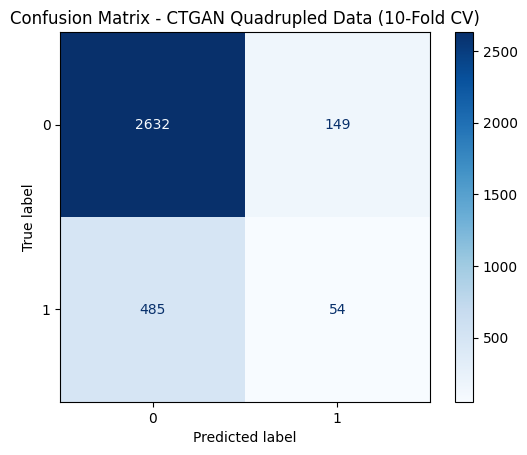

In [28]:
# Calculate and display confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions using cross-validation
y_pred = cross_val_predict(ilp_model, X, y, cv=10)

# Calculate confusion matrix
cm = confusion_matrix(y, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - CTGAN Quadrupled Data (10-Fold CV)')
plt.show()

In [29]:
smote_results

,case,accuracy,recall,precision,f1,mcc
0,UNBALANCED,0.6493,0.7852,0.7393,0.7589,0.1028
1,BAL-AUG,0.7506,0.6189,0.8472,0.7061,0.5250
2,DD-AUG,0.8813,0.8241,0.9338,0.8729,0.7707
3,TD-AUG,0.9241,0.8933,0.9538,0.9213,0.8518
4,QD-AUG,0.9500,0.9265,0.9728,0.9486,0.9018


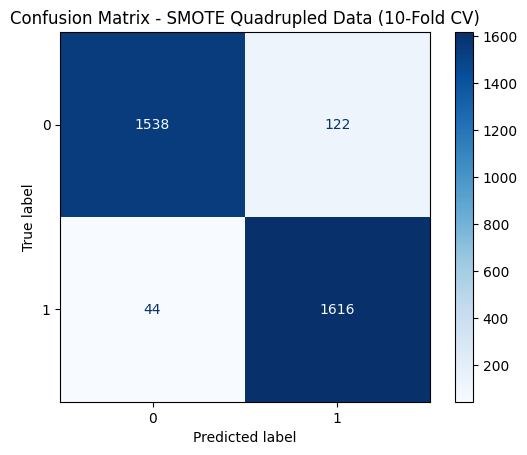

In [30]:
# Calculate and display confusion matrix for SMOTE-quadrupled data
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Get predictions using cross-validation on quadrupled data
y_pred = cross_val_predict(ilp_model, X_quad, y_quad, cv=10)

# Calculate confusion matrix
cm = confusion_matrix(y_quad, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - SMOTE Quadrupled Data (10-Fold CV)')
plt.show()

# Post-hoc Model Explainability Using SHAP

  0%|          | 0/50 [00:00<?, ?it/s]

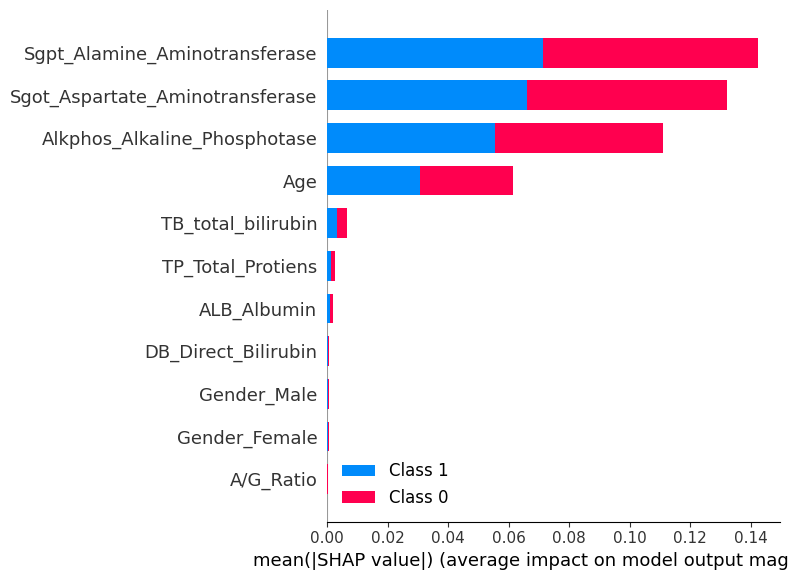

In [31]:
# SHAP EXPLANATION FOR THE KNN ILP MODEL

# Train the model on the selected feature set
ilp_model.fit(X, y)

# Use a small background dataset (first 50 rows) for Kernel SHAP efficiency
background = X[:50]

# KernelExplainer works for any model, including non-differentiable ones like KNN
explainer = shap.KernelExplainer(ilp_model.predict_proba, background)

# Compute SHAP values for the same subset
shap_values = explainer.shap_values(X[:50])

# Global summary plot showing feature importance across predictions
shap.summary_plot(shap_values, X[:50])

## 1. Dev Notes
### 15-11-25, 3:00
I have been able to apply KNN to the ILP dataset and with an accuracy of 0.67 and precision of 0.80, however this is without cross validation or data augmentation 

Other Metrics:
- Accuracy: 0.667
- Precision: 0.802
- Recall: 0.739
- F1-score: 0.769
- Matthews Correlation Coefficient: 0.175
- Confusion Matrix:
     [[65 23]
     [16 13]]

### 15-11-25, 3:10
I tried scaling with StandardScalar but it resulted in sliglty worse metrics so going I would not be proceeding with it going forward 
Metrics
- Accuracy: 0.658
- Precision: 0.816
- Recall: 0.705
- F1-score: 0.756
- Matthews Correlation Coefficient: 0.201
- Confusion Matrix:
     [[62 26]
     [14 15]]


### 15-11-25. 17:30
Added 10 fold cross validation, there was a drop in precision but a rise in the MCC, change in other metrics were marginal at best 
Metrics
- Average accuracy: 0.649
- Average precision: 0.739
- Average recall: 0.785
- Average f1: 0.759
- Average mcc: 0.103

Next Id be Implementing SMOTE

### 16-11-25. 11:14 
I initially augmented the imbalanced dataset using SMOTE to equalize the number of samples for both outcomes — disease present and disease absent — bringing each class to 415 samples. This led to an increase of at least 5% in all evaluation metrics except recall, which dropped from 0.7 to 0.6. Conversely, the Matthews Correlation Coefficient (MCC) showed the greatest improvement, increasing from 0.1 to 0.5.
At this point, although accuracy, recall, precision, and F1-score were above average, they were still lower than the results reported in the original paper.

After progressively increasing SMOTE oversampling up to 4×, performance improved substantially (accuracy 95%, MCC 0.90) with only a 4% train-validation MCC gap, suggesting limited overfitting; however, because SMOTE produces synthetic interpolated samples, I will validate performance on a completely external dataset to ensure true generalizability..

I also included MCC as one of the evaluation metrics — although it was mentioned in the paper, it was not originally used — because it incorporates all values of the confusion matrix (TP, FP, TN, FN) and provides a more reliable measure of performance on imbalanced datasets.

Next: looking into augmentation with CTGAN

### 16-11-25. 17:26
Implemended CTGAN with variying results. Each time the model is fit to the data, it generates differnet data so, so reproducability is low. 

### 16-11-25. 18:46

| Case    | Accuracy | Recall | Precision | F1 Score | MCC    |
| ------- | -------- | ------ | --------- | -------- | ------ |
| BAL-AUG | 0.7169   | 0.8661 | 0.7793    | 0.8192   | 0.1739 |
| DD-AUG  | 0.7783   | 0.9203 | 0.8278    | 0.8696   | 0.0884 |
| TD-AUG  | 0.8096   | 0.9417 | 0.8481    | 0.8912   | 0.1183 |
| QD-AUG  | 0.8090   | 0.9465 | 0.8453    | 0.8916   | 0.0592 |


I was able to specify the seeds,so the results are now more consistent. 
Augmenting the data with CTGAN showed promising results with accuracy, recall, precision, f1 and mcc at 0.8090, 0.9465,	0.8453,	0.8916, and	0.0592 respectively and while good they still below the outcomes seen in SMOTE augmentation. 
A worrisome metric is mcc which is significatly low at 5% and especially when compared to the values of the other metrics indicating that there the datasets may be inbalanced. 

--------
Upon inspection, the GAN-generated dataset was found to be highly imbalanced, with 2781 samples of class 1 and 539 of class 2.

------
I explored several approaches, such as oversampling the minority class and then augmenting with a GAN, or using a GAN followed by random undersampling of the majority class. Unfortunately, all of these strategies performed poorly.

I also considered using SMOTE to balance the dataset before generating new data with a GAN. While SMOTE initially improved performance, the Matthews Correlation Coefficient (MCC) later dropped from 50% to 10%, and the other metrics remained low, as shown in the table below:

| Case    | Accuracy | Recall | Precision | F1 Score | MCC    |
| ------- | -------- | ------ | --------- | -------- | ------ |
| BAL-AUG | 0.7506   | 0.6189 | 0.8472    | 0.7061   | 0.5250 |
| DD-AUG  | 0.6590   | 0.7166 | 0.7396    | 0.7166   | 0.2892 |
| TD-AUG  | 0.6426   | 0.7380 | 0.7159    | 0.7184   | 0.2319 |
| QD-AUG  | 0.6307   | 0.7447 | 0.7034    | 0.7179   | 0.1865 |


I realized that the issue stemmed from the GAN itself, which generates data randomly. As a result, some imbalance was inevitable. In the end, I reverted to the original approach, using only the GAN.


### FINAL RESULTS:

**KNN WITH SMOTE**

|   | case       | accuracy | recall | precision | f1     | mcc    |
| - | ---------- | -------- | ------ | --------- | ------ | ------ |
| 0 | UNBALANCED | 0.6493   | 0.7852 | 0.7393    | 0.7589 | 0.1028 |
| 1 | BAL-AUG    | 0.7506   | 0.6189 | 0.8472    | 0.7061 | 0.5250 |
| 2 | DD-AUG     | 0.8813   | 0.8241 | 0.9338    | 0.8729 | 0.7707 |
| 3 | TD-AUG     | 0.9241   | 0.8933 | 0.9538    | 0.9213 | 0.8518 |
| 4 | QD-AUG     | 0.9500   | 0.9265 | 0.9728    | 0.9486 | 0.9018 |




**KNN WITH CTGAN**

|   | case    | accuracy | recall | precision | f1     | mcc    |
| - | ------- | -------- | ------ | --------- | ------ | ------ |
| 0 | BAL-AUG | 0.7169   | 0.8661 | 0.7793    | 0.8192 | 0.1739 |
| 1 | DD-AUG  | 0.7783   | 0.9203 | 0.8278    | 0.8696 | 0.0884 |
| 2 | TD-AUG  | 0.8096   | 0.9417 | 0.8481    | 0.8912 | 0.1183 |
| 3 | QD-AUG  | 0.8090   | 0.9465 | 0.8453    | 0.8916 | 0.0592 |


### SHAP Explanation

The model’s predictions are driven almost entirely by liver enzyme values.

Key points:

Top drivers: SGPT (ALT), SGOT (AST), and Alkaline Phosphatase are the strongest contributors for both classes.

Moderate influence: Age has a noticeable but smaller effect.

Minimal influence: Bilirubin, proteins, albumin, gender, and A/G ratio contribute very little to the model’s decisions.



### SUMMARY:

Overall Summary

Baseline KNN achieved moderate performance (accuracy ~ 0.65 – 0.67, F1 ~ 0.76) with weak MCC (~ 0.1 – 0.2). Standard scaling did not help.

Cross-validation slightly reduced precision but confirmed stability; metrics largely unchanged.

SMOTE augmentation significantly improved results. Light oversampling gave small gains, while heavier oversampling (up to 4×) produced very strong improvements — reaching 95% accuracy, 0.95 precision, 0.90 MCC, with only mild signs of overfitting.

CTGAN augmentation improved some metrics (accuracy up to ~0.81), but MCC remained very low (0.05–0.17) because the GAN produced heavily imbalanced synthetic data. Attempts to rebalance before/after GAN generation did not solve the problem.

Best performing approach: KNN + high-level SMOTE augmentation, which gave the strongest and most stable metrics:

- Accuracy: 0.95
- Recall: 0.93
- Precision: 0.97
- F1: 0.95 
- MCC: 0.90

SHAP analysis showed the model relies almost entirely on liver enzymes (ALT, AST, ALP), with age as a secondary factor and all other labs contributing minimally.